AIM= a detailed Batting Intent Analysis with Python using ball-by-ball data from a recent IPL match between RCB and DC in 2025.
The scope of our analysis is to understand batting intent: how players approach the game in various situations; by examining strike rates, boundary percentages, dot ball rates, and over-wise performance, ultimately uncovering insights that can influence real-time strategy and decision-making.

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("ipl_match_1473461_deliveries.csv")
df.head()

,team,over,batter,bowler,non_striker,runs_batter,runs_extras,runs_total,extras_type,wicket_kind,player_out,fielders
0,Royal Challengers Bengaluru,0,PD Salt,MA Starc,V Kohli,0,0,0,NaN,NaN,NaN,NaN
1,Royal Challengers Bengaluru,0,PD Salt,MA Starc,V Kohli,0,0,0,NaN,NaN,NaN,NaN
2,Royal Challengers Bengaluru,0,PD Salt,MA Starc,V Kohli,0,5,5,wides,NaN,NaN,NaN
3,Royal Challengers Bengaluru,0,PD Salt,MA Starc,V Kohli,1,0,1,NaN,NaN,NaN,NaN
4,Royal Challengers Bengaluru,0,V Kohli,MA Starc,PD Salt,1,0,1,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   team         236 non-null    object
 1   over         236 non-null    int64 
 2   batter       236 non-null    object
 3   bowler       236 non-null    object
 4   non_striker  236 non-null    object
 5   runs_batter  236 non-null    int64 
 6   runs_extras  236 non-null    int64 
 7   runs_total   236 non-null    int64 
 8   extras_type  11 non-null     object
 9   wicket_kind  11 non-null     object
 10  player_out   11 non-null     object
 11  fielders     11 non-null     object
dtypes: int64(4), object(8)
memory usage: 22.3+ KB


In [5]:
import seaborn as sns
from math import pi
df_copy = df.copy()

In [9]:
# add game phase based on overs
def get_phase(over):
    if over < 6:
        return 'Powerplay'
    elif 6 <= over <15:
        return 'Middle Overs'
    else:
        return 'Death Overs'

df_copy['phase'] = df_copy['over'].apply(get_phase)

we defined a function "get_phase" that assigns a phase label based on the over numbers . overs 0-5 as powerplay , 6-14 middle overs and 15-20 death overs . then we applied this function to the over column to create a new phase column in dataset

## lets calculate each batters strike rate across different phases of the game and visualize their batting intent

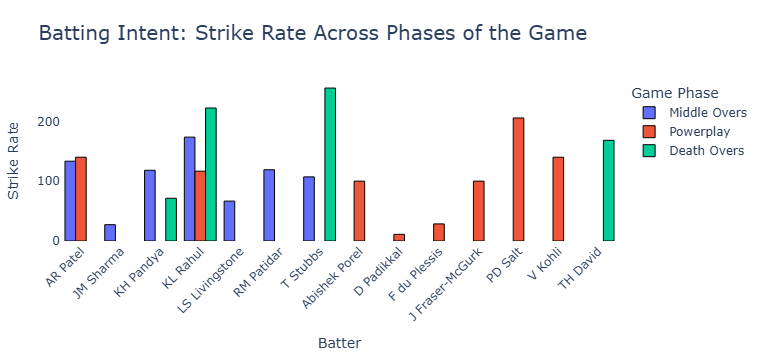

In [15]:
import plotly.express as px

batting_intent = (
    df_copy.groupby(['batter', 'phase'])
    .agg(balls_faced=('runs_batter', 'count'),
         total_runs=('runs_batter', 'sum'))
    .reset_index()
)

batting_intent['strike_rate'] = (batting_intent['total_runs'] / batting_intent['balls_faced']) * 100

batting_intent = batting_intent[batting_intent['balls_faced'] >=5]

batting_intent.sort_values(by=['batter', 'phase'], inplace=True)

fig = px.bar(
    batting_intent,
    x='batter',
    y='strike_rate',
    color='phase',
    barmode='group',
    title='Batting Intent: Strike Rate Across Phases of the Game',
    labels={'strike_rate': 'Strike Rate', 'batter': 'Batter'},
    hover_data={
        'balls_faced': True,
        'total_runs': True,
        'strike_rate': ':.2f',
        'phase': True
    }
)

fig.update_layout(
    xaxis_tickangle=-45,
    title_font_size=20,
    legend_title='Game Phase',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='white',
    bargap=0.2,
    margin=dict(l=40, r=40, t=80, b=100)
)

fig.update_traces(marker_line_width=1, marker_line_color='black')

fig.show()



T Stubbs and KL Rahul showcased aggressive intent in the Death Overs, with Strike rates exceeding 220 and 220 resp, indicating high-impact of finishing roles.PD Salt and AR Patel were strong starters with strike rates 140 in the Powerplay.

## Team wise batting intent across match phases
compare the batting intent of both teams across different match phases using strike rate as a metric

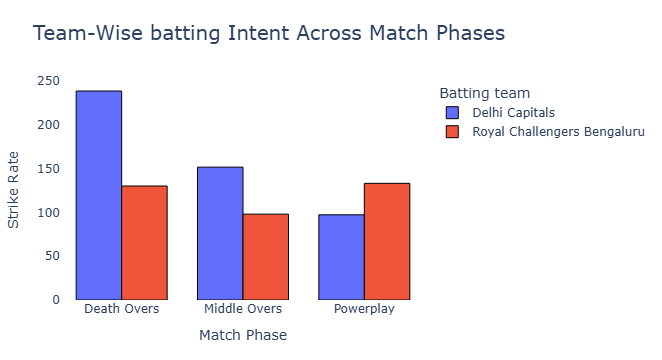

In [17]:
df_copy['batting_team'] = df_copy['team']

team_phase_intent = (
    df_copy.groupby(['batting_team', 'phase'])
    .agg(balls_faced=('runs_batter', 'count'),
         total_runs=('runs_batter', 'sum'))
    .reset_index()
)

team_phase_intent['strike_rate'] = (team_phase_intent['total_runs'] / team_phase_intent['balls_faced']) *100

fig = px.bar(
    team_phase_intent,
    x='phase',
    y='strike_rate',
    color='batting_team',
    barmode='group',
    title =' Team-Wise batting Intent Across Match Phases',
    labels = {
        'phase': 'Match Phase',
        'strike_rate': 'Strike Rate',
        'batting_team': 'Team'
    },
    hover_data={
        'balls_faced': True,
        'total_runs': True,
        'strike_rate': ':.2f'
    }
)

fig.update_layout(
    xaxis_title = 'Match Phase',
    yaxis_title = 'Strike Rate',
    title_font_size =20,
    legend_title_text = ' Batting team',
    bargap=0.25,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='pink',
    margin=dict(l=40, r=40, t=80, b=60)
)

fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.show()

## Boundary % vs Dot Ball % per Batter
Now calculate each batters ability to rotate strike and score boundaries by calculating their boundary %and dot ball %

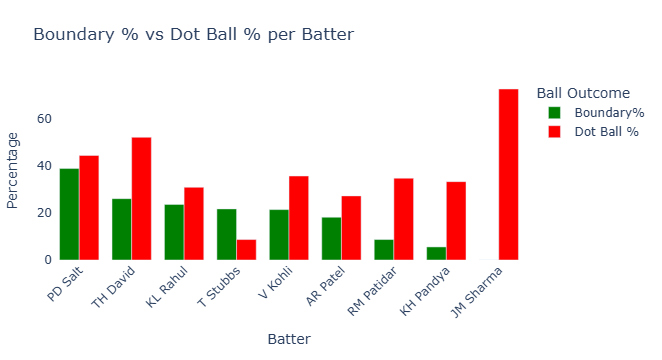

In [22]:
import plotly.graph_objects as go 
df_copy['ball_outcome'] = df_copy['runs_batter'].apply(
    lambda x: 'Dot' if x == 0 else ('Boundary' if x >= 4 else 'Run')
)

batter_outcome_stats = (
    df_copy.groupby('batter')
    .ball_outcome.value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
).reset_index()

balls_faced = df_copy.groupby('batter').size().reset_index(name='balls_faced')
batter_outcome_stats = batter_outcome_stats.merge(balls_faced, on='batter')
batter_outcome_stats = batter_outcome_stats[batter_outcome_stats['balls_faced'] >=10]

batter_outcome_stats = batter_outcome_stats.sort_values(by='Boundary', ascending=False)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=batter_outcome_stats['batter'],
    y=batter_outcome_stats['Boundary'],
    name='Boundary%',
    marker_color = 'green',
    hovertemplate='%{x}<br>Boundary %: %{y:.2f}<extra></extra>'
))

fig.add_trace(go.Bar(
    x=batter_outcome_stats['batter'],
    y=batter_outcome_stats['Dot'],
    name='Dot Ball %',
    marker_color='red',
    hovertemplate='%{x}<br>Dot Ball %: %{y: .2f}<extra></extra>'
))

fig.update_layout(
    title= 'Boundary % vs Dot Ball % per Batter',
    xaxis_title = 'Batter',
    yaxis_title = 'Percentage',
    barmode = 'group',
    bargap = 0.25,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='white',
    legend_title_text='Ball Outcome',
    xaxis_tickangle=-45,
    margin=dict(l=40, r=40, t=80, b=100)
)

fig.show()




## Over-WIse Run progression of top 4 Batters
lets track how top4 run scorers progressed throughout the innings by analyzing their overwise scoring patterns

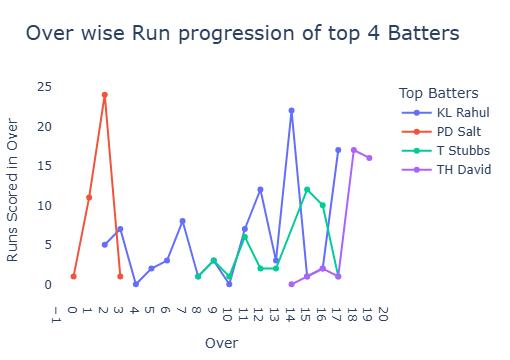

In [26]:
top_batters = (
    df_copy.groupby('batter')['runs_batter']
    .sum()
    .sort_values(ascending=False)
    .head(4)
    .index.tolist()
)

batters_progression = df_copy[df_copy['batter'].isin(top_batters)]
batters_overwise =(
    batters_progression.groupby(['batter', 'over'])
    .agg(runs_in_over=('runs_batter', 'sum'))
    .reset_index()
)

fig = px.line(
    batters_overwise,
    x='over',
    y='runs_in_over',
    color='batter',
    markers=True,
    title='Over wise Run progression of top 4 Batters',
    labels={
        'over': 'Over',
        'runs_in_over': 'Runs in Over',
        'batter': 'Batter'
    },
)

fig.update_layout(
    xaxis=dict(tickmode='linear'),
    yaxis_title='Runs Scored in Over',
    legend_title='Top Batters',
    title_font_size=20,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='white',
    margin=dict(l=40, r=40, t=80, b=60),
    hovermode='x unified'
)

fig.show()

    

## Correlating Batting Tempo with Wicket Falls
lets compare how runs and wickets fluctuated over each over to understand momentum shifts during the innings

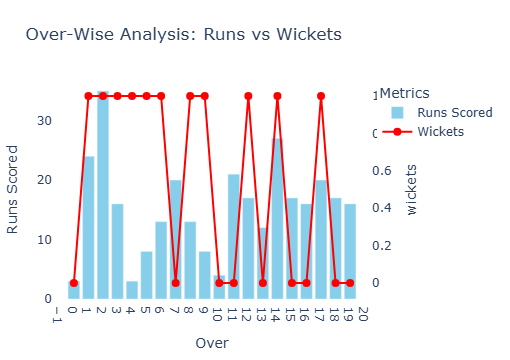

In [31]:
wickets_df = df_copy[df_copy['player_out'].notna()]
wicket_by_over = wickets_df.groupby('over').size().reset_index(name='wickets')
runs_by_over = df_copy.groupby('over')['runs_batter'].sum().reset_index(name='total_runs')

overwise_analysis = pd.merge(runs_by_over, wicket_by_over, on='over', how='left').fillna(0)
fig = go.Figure()

fig.add_trace(go.Bar(
    x=overwise_analysis['over'],
    y=overwise_analysis['total_runs'],
    name='Runs Scored',
    marker_color='skyblue',
    hovertemplate='Over %{x}<br>Runs: %{y}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=overwise_analysis['over'],
    y=overwise_analysis['wickets'],
    name='Wickets',
    mode='lines+markers',
    marker=dict(color='red', size=8),
    line=dict(width=2, color='red'),
    yaxis='y2',
    hovertemplate='Over %{x}<br>Wickets: %{y}<extra></extra>'
))

fig.update_layout(
    title='Over-Wise Analysis: Runs vs Wickets',
    xaxis=dict(title='Over', tickmode='linear'),
    yaxis=dict(title='Runs Scored'),
    yaxis2=dict(title='wickets', overlaying='y', side='right'),
    legend_title = 'Metrics',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='white',
    margin=dict(l=40, r=40, t=80, b=60),
    hovermode='x unified'
)

fig.show()


## Batter Profile Based on match performance
lets build comprehensive performance profiles for each batter including their strike rate average dot ball% and boundary%.

In [32]:
batter_stats = (
    df_copy.groupby('batter')
    .agg(
        balls_faced=('runs_batter','count'),
        total_runs=('runs_batter','sum'),
        dismissals=('player_out', lambda x: x.notna().sum())
    )
    .reset_index()
)
outcome_counts = df_copy.groupby(['batter', 'ball_outcome']).size().unstack().fillna(0)
outcome_counts['dot_percent'] = (outcome_counts['Dot'] / outcome_counts.sum(axis=1)) * 100
outcome_counts['boundary_percent'] = (outcome_counts['Boundary']/ outcome_counts.sum(axis=1)) * 100
outcome_counts = outcome_counts[['dot_percent', 'boundary_percent']]

batter_profiles = pd.merge(batter_stats, outcome_counts, on='batter')
batter_profiles['strike_rate'] = (batter_profiles['total_runs'] / batter_profiles['balls_faced']) * 100
batter_profiles['average'] = batter_profiles.apply(
    lambda row: row['total_runs'] / row['dismissals'] if row['dismissals'] > 0 else float('inf'), axis=1
)
batter_profiles = batter_profiles[batter_profiles['balls_faced'] >= 10]


lets visualize the performance profiles of the top 4 batters using radar charts to compare strike rate , dot ball % and boundary %

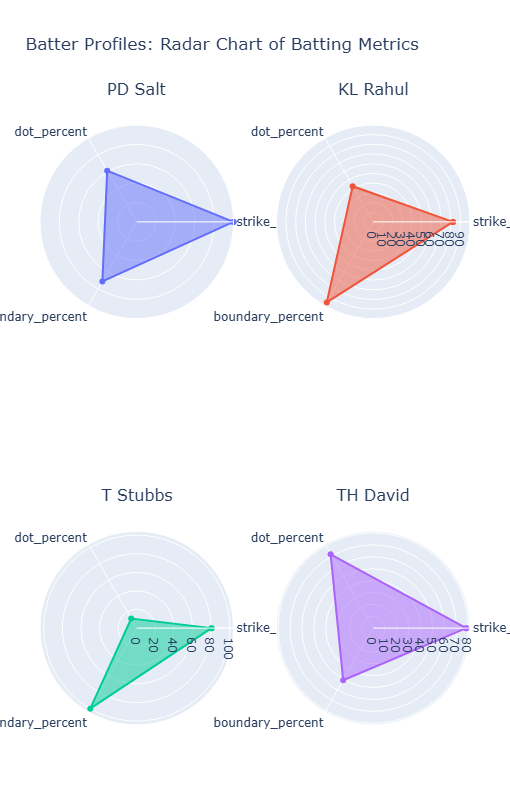

In [35]:
from plotly.subplots import make_subplots
from math import pi, ceil

metrics = ['strike_rate', 'dot_percent', 'boundary_percent']
top_batters_radar = batter_profiles.sort_values(by='strike_rate', ascending=False).head(4).copy()
normalized_profiles = top_batters_radar[['batter'] + metrics].copy()

for metric in metrics:
    max_val = batter_profiles[metric].max()
    normalized_profiles[metric] = (normalized_profiles[metric] / max_val) * 100

normalized_profiles.reset_index(drop=True, inplace=True)

num_batters = len(normalized_profiles)
rows = ceil(num_batters / 2)
cols = 2 if num_batters > 1 else 1

fig = make_subplots(
    rows=rows, cols=cols,
    specs=[[{'type': 'polar'}] * cols for _ in range(rows)],
    subplot_titles=normalized_profiles['batter'].tolist()
)

for i, row in normalized_profiles.iterrows():
    r = row[metrics].tolist() + [row[metrics[0]]]
    theta = metrics + [metrics[0]]

    subplot_row = (i // cols) + 1
    subplot_col = (i % cols) + 1

    fig.add_trace(
        go.Scatterpolar(
            r=r,
            theta=theta,
            fill='toself',
            name=row['batter'],
            hovertemplate='<b>%{theta}</b>: %{r:.1f}<extra></extra>'
        ),
        row=subplot_row, col=subplot_col
    )
fig.update_layout(
    title='Batter Profiles: Radar Chart of Batting Metrics',
    showlegend=False,
    height=400 * rows,
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 100], showticklabels=False)
    ),
    margin=dict(l=40, r=40, t=100, b=50)
)

fig.show()
    

# Summary
By examining strike rates, boundary and dot ball percentages, over-wise run patterns, and wicket impacts, we decoded how each player approached different match phases. From aggressive Powerplay openers like PD Salt to high-impact finishers like T Stubbs and TH David, and steady anchors like KL Rahul, the data revealed distinct batting styles.